In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import scipy.stats as sps
import progressbar

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# and by putting size by lost gas mass

def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [5]:
List = h5py.File('SatelliteList_V2_withAngles_n500_KoK04.h5', 'r')
sats = List['SatelliteList'][()]

In [6]:
nearest, distT, velT = [], [], []
groupList = sim['SnapNumber_128/SubGroups/GroupNumber'][()]

for s in sats:
    posSat = sim['SnapNumber_128/SubGroups/SubGroupPos'][s]
    vel = sim['SnapNumber_128/SubGroups/SubGroupVel'][s]
    gro = sim['SnapNumber_128/SubGroups/GroupNumber'][s]
    ii = np.where(groupList==gro)[0][1:] # ignore the first one, is the central and I don't care about it
    if ii.size>1:
        ij = np.where(ii!=s)
        ii2 = ii[ij] # remove the same galaxy from the list
        posOtherGals = sim['SnapNumber_128/SubGroups/SubGroupPos'][ii2]
        dist = np.sqrt((posOtherGals[:,0]-posSat[0])**2.+(posOtherGals[:,1]-posSat[1])**2.+(posOtherGals[:,2]-posSat[2])**2.)
        velOtherGals = sim['SnapNumber_128/SubGroups/SubGroupVel'][ii2]
        difVel = np.sqrt((vel[0]-velOtherGals[:,0])**2+(vel[1]-velOtherGals[:,1])**2+(vel[2]-velOtherGals[:,2])**2)
        nearest.append(ii2)
        distT.append(dist)
        velT.append(difVel)
    else:
        nearest.append(np.array([-1])) # there's no nearest galaxy
        distT.append(np.array([-1]))
        velT.append(np.array([-1]))

In [7]:
nearest, distT, velT = np.array(nearest), np.array(distT), np.array(velT)
nearest.shape

(11,)

In [8]:
ij = []

for i, nn in enumerate(nearest):
    if nn[0] != -1:
        ij.append(i)
        
ij = np.array(ij)

cent = List['SatelliteCentral'][()]

satS, cenS, nearS , distS, velS = sats[ij], cent[ij], nearest[ij], distT[ij], velT[ij]

In [9]:
# lets go back in time, at a time when the tow galaxies where separated.

def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb


def sepTime(sat, near, cent):
    
    unique = int(128*1e6+sat)
    uniqueC = int(128*1e6+cent)
    #uniqueN = int(128*1e6+near)
    
    stree = networkx.dfs_tree(trees, str(unique))
    mtree = get_main_branch_unique_ids(stree, str(unique))
    
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    snapT, nuT, snapNT, nuNT, distT, velRT, isinT = [], [], [], [], [], [], []
    
    
    for nn in near:
        uniqueN = int(128*1e6+nn)
    
        streeN = networkx.dfs_tree(trees, str(uniqueN))
        mtreeN = get_main_branch_unique_ids(streeN, str(uniqueN))

        end = True
        
        for m, mC, mN in zip(mtree, mtreeC, mtreeN):
            snap, nu = split_unique_id(int(m))
            snapC, nuC = split_unique_id(int(mC))
            snapN, nuN = split_unique_id(int(mN))
        
            group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][nu]
            groupN = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snapN)][nuN]
            groupC = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snapC)][nuC]
        
            if groupC!=group and groupC!=groupN: # both galaxies are outside the group
                pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][nu]
                pnear = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapN)][nuN]
            
                vgal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][nu]
                vnear = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snapN)][nuN]
            
                dist = np.sqrt(np.sum((pgal-pnear)**2.))
                velR = np.sqrt(np.sum((vgal-vnear)**2.))
                snapT.append(snap)
                nuT.append(nu)
                snapNT.append(snapN)
                nuNT.append(nuN)
                distT.append(dist)
                velRT.append(velR)
                isinT.append(groupN==group)
                end = False
                
                break
        if end: # never broke
            snapT.append(None)
            nuT.append(None)
            snapNT.append(None)
            nuNT.append(None)
            distT.append(None)
            velRT.append(None)
            isinT.append(False)
    
    return np.array(snapT), np.array(nuT), np.array(snapNT), np.array(nuNT), np.array(distT), np.array(velRT), np.array(isinT)

In [10]:
sepTime(satS[0], nearS[0], cenS[0])

(array([109, 125, 125, 124]),
 array([275, 249, 249, 248]),
 array([109, 125, 125, 124]),
 array([ 419,  250, 1164, 1711]),
 array([168.06001 ,  18.105337,  35.725155,  77.23335 ], dtype=float32),
 array([42.27413 , 29.090672, 31.011703, 23.795033], dtype=float32),
 array([False,  True, False, False]))

In [11]:
distS[0], velS[0]

(array([50.891636, 12.898574, 29.676098, 74.85492 ], dtype=float32),
 array([71.87826 , 33.61524 , 34.118958, 31.112669], dtype=float32))

In [12]:
# ok, all of them.

distThen, velThen, snapThen, idThen, snapNear, idNear, sameG = [], [], [], [], [], [], []

issI, issV = [], []

k = np.arange(satS.size)

bar = progressbar.ProgressBar(max_value=satS.size)
C = 0

for ki, s, c, n in zip(k, satS, cenS, nearS):
    snap, nu, snapN, nuN, dist, velR, isin = sepTime(s, n, c)
    i = np.where(snap!=None)[0]

    if i.size>0:
        issI.append(ki)
        issV.append(i)
        snapThen.append(snap[i])
        idThen.append(nu[i])
        snapNear.append(snapN[i])
        idNear.append(nuN[i])
        distThen.append(dist[i])
        velThen.append(velR[i])
        sameG.append(isin[i])
    C += 1
    bar.update(C)
        
distThen, velThen, snapThen = np.array(distThen), np.array(velThen), np.array(snapThen)
idThen, snapNear, idNear, sameG = np.array(idThen), np.array(snapNear), np.array(idNear), np.array(sameG)

100% (11 of 11) |########################| Elapsed Time: 0:00:55 ETA:  00:00:00

In [13]:
issI, issV = np.array(issI), np.array(issV)

distSi, velSi = distS[issI], velS[issI]

In [14]:
# lets do this plain, but this is not how I gonna select pairs
distSI, velSI, distTI, velTS, isinTI = [], [], [], [], []

for iss ,dd, vv, d2, v2, iin in zip(issV ,distSi, velSi, distThen, velThen, sameG):
    distSI.extend(list(dd[iss]))
    velSI.extend(list(vv[iss]))
    distTI.extend(list(d2))
    velTS.extend(list(v2))
    isinTI.extend(list(iin))

distSI, velSI, distTI, velTS, isinTI = np.array(distSI), np.array(velSI), np.array(distTI), np.array(velTS), np.array(isinTI)

In [15]:
distSI.size, velSI.size, distTI.size, velTS.size, isinTI.size, np.where(isinTI)[0].size

(1078, 1078, 1078, 1078, 1078, 75)

Text(0, 0.5, 'vel/vel z=0')

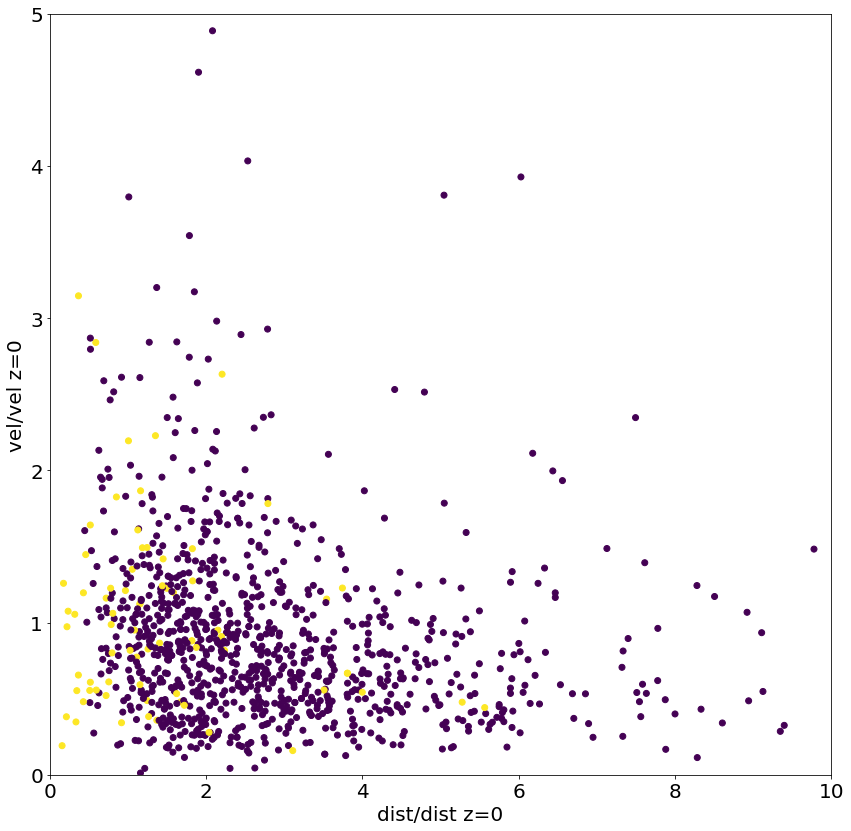

In [16]:
pl.figure(figsize=(14,14))

DD = distTI/distSI
VV = velTS/velSI

pl.scatter(DD, VV, c=isinTI)
#bar = pl.colorbar() # idk what is going to do this

pl.xlim(0,10)
pl.ylim(0,5)

pl.xlabel('dist/dist z=0')
pl.ylabel('vel/vel z=0')

In [17]:
# anyway, lets study the potential pairs 
satSi, cenSi, nearSi = satS[issI], cenS[issI], nearS[issI]

In [18]:
MassPotPairs = []
havePairs = []

c = 0
for are, sat, near in zip(sameG, satSi, nearSi):
    k = np.where(are)[0]
    if k.size>0:
        havePairs.append(c)
        offGal = sim['SnapNumber_128/SubGroups/PartType1/Offsets'][sat].astype('int') # each galaxy actually has DM
        massGal = offGal[1] - offGal[0]
        nn = near[k]
        pm = []
        for nn in near:
            offNN = sim['SnapNumber_128/SubGroups/PartType1/Offsets'][nn].astype('int')
            massNN = offNN[1]-offNN[0]
            pm.append(massNN)
        pm = np.array(pm)
        dmass = pm/massGal
        
        MassPotPairs.append(dmass)

    c += 1
    
MassPotPairs, havePairs = np.array(MassPotPairs), np.array(havePairs)

In [19]:
MassPotPairs

array([array([0.19028741, 0.04558969, 0.03171457, 0.0123885 ]),
       array([0.47923103, 0.52488843, 0.45485754, 0.02265705, 0.06247854,
       0.21215242, 0.15859938, 0.30930312, 0.19876416, 0.17507724,
       0.17370409, 0.17233093, 0.13044971, 0.15139032, 0.05183659,
       0.13216615, 0.11877789, 0.02231377, 0.10744936, 0.10744936,
       0.09612084, 0.08891177, 0.09783728, 0.09783728, 0.08719533,
       0.08616547, 0.06968761, 0.06968761, 0.05835908, 0.06591143,
       0.06247854, 0.0425678 , 0.05526948, 0.05526948, 0.05046344,
       0.04943357, 0.04119464, 0.0456574 , 0.04394095, 0.04085136,
       0.02574665, 0.02403021, 0.03776176, 0.03673189, 0.02403021,
       0.02986612, 0.01716444, 0.02917954, 0.02471679, 0.02849296,
       0.02814967, 0.02780639, 0.02677652, 0.02643323, 0.0243735 ,
       0.02403021, 0.02265705, 0.02162719, 0.0212839 , 0.01991074,
       0.01647786, 0.01956746, 0.01888088, 0.01888088, 0.01853759,
       0.01853759, 0.01750772, 0.01853759, 0.01853759, 0.0

In [20]:
# ok, lets see the distribution of this stuff

PlaneMassScale = []

for m in MassPotPairs:
    PlaneMassScale.extend(list(m))
    
PlaneMassScale = np.array(PlaneMassScale)

Text(0.5, 0, 'mu')

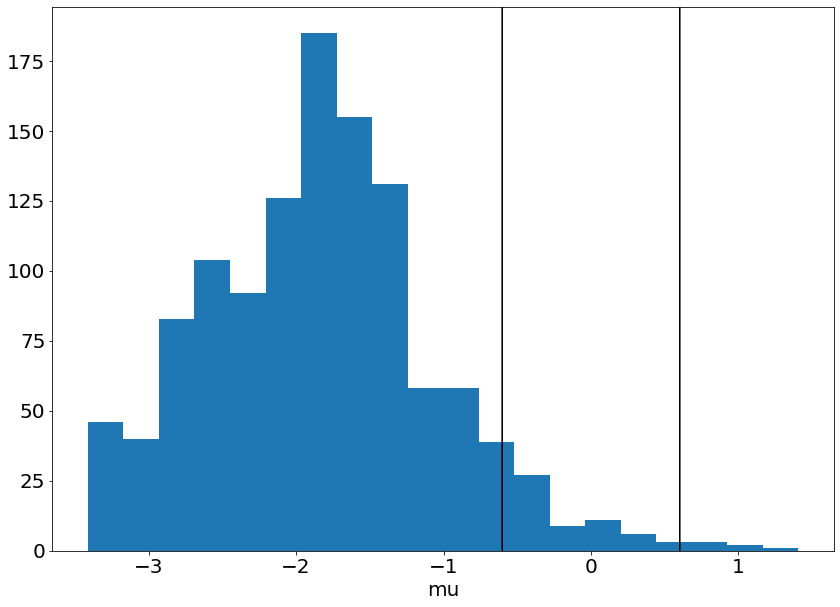

In [21]:
pl.figure(figsize=(14,10))

pl.hist(np.log10(PlaneMassScale), bins=20)

pl.arrow(np.log10(0.25), 0., 0., 4000)
pl.arrow(np.log10(4.), 0., 0., 4000)

pl.xlabel('mu')

In [22]:
Spairs, MMu = [], []

for mu, index in zip(MassPotPairs, havePairs):
    j = np.where(mu>0.1)[0]
    if j.size>0: # there is a least one in the range:
        Spairs.append(index)
        MMu.append(mu[j].max())
            
Spairs = np.array(Spairs)
MMu = np.array(MMu)

In [23]:
Spairs.size

9

In [24]:
SatsWithPairs = satSi[Spairs]

SatsWithPairs

array([ 152, 4338, 4339, 4341, 4470, 4471, 4473, 4474, 4476])

In [25]:
withP = []
FMu = []

for s in sats:
    if s in SatsWithPairs:
        withP.append(True)
        ik = np.where(SatsWithPairs==s)[0][0]
        FMu.append(MMu[ik])
    else:
        withP.append(False)
        FMu.append(0.)
        
withP = np.array(withP)
FMu = np.array(FMu)

In [26]:
withP

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False])

In [27]:
# with h5py.File('SatelliteList_V2_withAngles_n500_KoK04_PairsV2.h5', 'w') as f:
#     f.create_dataset('SatelliteList', data=sats)
#     f.create_dataset('SatelliteCentral', data=cent)
#     f.create_dataset('inGroup', data=withP)
#     f.create_dataset('Mu', data=FMu)